In [114]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
import pandas as pd 
import matplotlib.pyplot as plt

from dln import (
    create_dln_model, 
    create_minibatches, 
    true_dln_learning_coefficient, 
    mse_loss, 
)
from sgld_utils import (
    SGLDConfig, 
    run_sgld
)

import os
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=11)

IMAGEDIR = "./images/autogenerated_testrun/"
DRYRUN = False
OPEN_SAVEDIMAGES = True
BURN_IN = 49000

os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return





(10000, 5) (10000, 5)
(5, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 5)


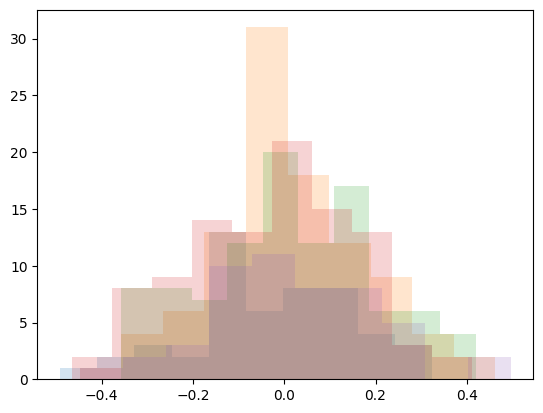

In [109]:
NUM_TRAINING_STEPS = 20000
NUM_TRAINING_DATA = 10000
BATCH_SIZE = 128
RNGSEED = 42
WIDTH = 10
LENGTH = 4
LR = 1e-4
EXPONENT = 1.5
SIGMA = np.sqrt(WIDTH ** (-EXPONENT))


rngkey = jax.random.PRNGKey(RNGSEED)

teacher_matrix = 10.0 * np.diag([1, 2, 3, 4, 5])
input_dim = teacher_matrix.shape[0]
output_dim = teacher_matrix.shape[1]
layer_widths = [WIDTH] * LENGTH + [output_dim]
itemp = 1 / np.log(NUM_TRAINING_DATA)

rngkey, key = jax.random.split(rngkey)
x_train = jax.random.normal(key, shape=(NUM_TRAINING_DATA, input_dim))
y_train = x_train @ teacher_matrix 
print(x_train.shape, y_train.shape)

model = create_dln_model(layer_widths, sigma=SIGMA)
rngkey, subkey = jax.random.split(rngkey)
init_param = model.init(rngkey, jnp.zeros((1, input_dim)))
jtree.tree_map(lambda x: print(x.shape), init_param)
loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))



for x in jtree.tree_leaves(init_param):
    plt.hist(np.ravel(x), alpha=0.2)

In [110]:
sgld_config = SGLDConfig(
    epsilon=1e-6, 
    gamma=1.0,
    num_steps=100, 
    num_chains=1.0,
    batch_size=BATCH_SIZE
)

optimizer = optax.sgd(learning_rate=LR)
max_steps = NUM_TRAINING_STEPS
t = 0
rngkey, subkey = jax.random.split(rngkey)
grad_fn = jax.jit(jax.value_and_grad(loss_fn, argnums=0))
trained_param = model.init(rngkey, jnp.zeros((1, input_dim)))
opt_state = optimizer.init(trained_param)
records = []
while t < max_steps:
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=BATCH_SIZE):
        train_loss, grads = grad_fn(trained_param, x_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        trained_param = optax.apply_updates(trained_param, updates)
        t += 1
        if t >= max_steps:
            break
        if t % 50 == 0: 
            rngkey, subkey = jax.random.split(rngkey)
            y_realisable = model.apply(trained_param, x_train)
            y = y_realisable
            # y = y_train
            
            loss_trace, distances, acceptance_probs = run_sgld(
                subkey, 
                loss_fn, 
                sgld_config, 
                trained_param, 
                x_train, 
                y,
                itemp=itemp, 
                trace_batch_loss=True, 
                compute_distance=False, 
                verbose=False
            )
            
            init_loss = loss_fn(trained_param, x_train, y)
            lambdahat = float(np.mean(loss_trace) - init_loss) * NUM_TRAINING_DATA * itemp

            true_matrix = jnp.linalg.multi_dot(
                [trained_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
            )
            true_rank = jnp.linalg.matrix_rank(true_matrix)
            true_lambda, true_multiplicity = true_dln_learning_coefficient(
                true_rank, 
                layer_widths, 
                input_dim, 
            )
            
            rec = {
                "t": t, 
                "train_loss": float(train_loss),
                "lambdahat": float(lambdahat),
                "true_lambda": true_lambda, 
                "true_multiplicity": true_multiplicity, 
                "loss_trace": loss_trace, 
                "true_rank": true_rank,
                "init_loss": float(init_loss),
            }
            print(
                rec["t"], rec["train_loss"], 
                rec["lambdahat"]
            )
            records.append(rec)



/Users/edmund/.local/share/virtualenvs/validating_lambdahat-UCObfUVw/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3961: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


50 970.9503784179688 0.023566082186743314
100 1122.9964599609375 0.036874529485281415
150 1210.4158935546875 0.030999371338463273
200 1089.92724609375 0.03637857793675115
250 1121.7880859375 0.044465521757609046
300 1184.00146484375 0.027882619542882067
350 1066.8358154296875 0.0476806138475791
400 1206.6082763671875 0.050182518597124366
450 1089.7166748046875 0.068260456348923
500 1128.0291748046875 0.05252371436334639
550 1128.3203125 0.1260804020699971
600 1083.9619140625 0.13021842830975197
650 1004.9020385742188 0.17203284630026544
700 1004.2080078125 0.1898640031181031
750 1042.7958984375 0.22857812453520765
800 1154.4691162109375 0.5584289067091291
850 1186.4517822265625 0.251246168699231
900 1098.4136962890625 1.1127300884793736
950 1014.7138061523438 2.2801124331633726
1000 984.6793212890625 5.048215310432023
1050 754.7401733398438 4.65201489212267
1100 781.1990356445312 4.845655080387691
1150 781.99755859375 4.846008484525521
1200 798.869873046875 3.82587230249894
1250 666.93

Saving file at: ./images/autogenerated_testrun/dln_saddletosaddle_transition.pdf


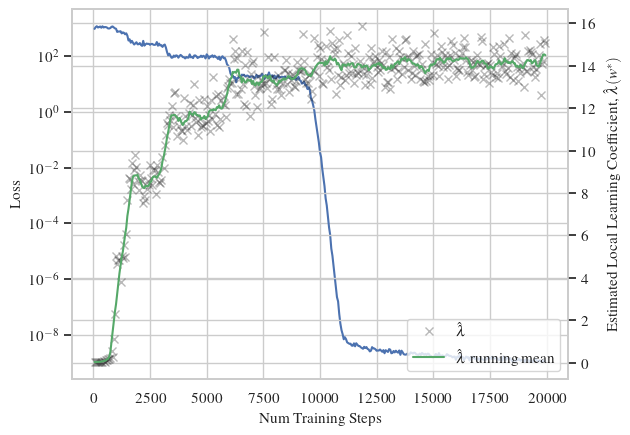

In [116]:
def running_mean(data, window_size=10):
    if window_size % 2 == 0:
        left_pad = window_size // 2
        right_pad = window_size // 2 - 1
    else:
        left_pad = right_pad = window_size // 2

    # Reflect the data for boundary cases
    pad_left = data[:left_pad][::-1]
    pad_right = data[-right_pad:][::-1]
    padded_data = np.concatenate([pad_left, data, pad_right])

    kernel = np.ones(window_size) / window_size
    return np.convolve(padded_data, kernel, mode='valid')


df_data = pd.DataFrame(records)
df = df_data

fig, ax = plt.subplots()
ax.plot(df["t"], df["train_loss"])
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.set_xlabel("Num Training Steps")

ax = ax.twinx()

ax.plot(df["t"], np.clip(df["lambdahat"], a_min=0, a_max=np.inf), "kx", alpha=0.3, label="$\hat{\lambda}$")
yvals = running_mean(df["lambdahat"])
ax.plot(df["t"], yvals, "g-", label="$\hat{\lambda}$ running mean")
ax.set_ylabel("Estimated Local Learning Coefficient, $\hat{\lambda}(w^*)$")
ax.legend()
savefig_fn(fig, "dln_saddletosaddle_transition.pdf")